In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-02 21:48:23.892265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
labels = labels.astype(np.float64)

In [6]:
import tensorflow as tf

images = images.astype(np.float64)

all_images = []
all_labels = []

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    
    mask = labels[i]
    image = images[i]
    
    all_images.append(image)
    all_labels.append(mask)

    image1 = tf.image.flip_left_right(image)
    mask1 = tf.image.flip_left_right(mask)
    
    all_images.append(image1)
    all_labels.append(mask1)
    

    image2 = tf.image.flip_up_down(image)
    mask2 = tf.image.flip_up_down(mask)
    
    all_images.append(image2)
    all_labels.append(mask2)

    image3 = tf.image.rot90(image)
    mask3 = tf.image.rot90(mask)
    
    all_images.append(image3)
    all_labels.append(mask3)

2023-04-02 21:48:29.359120: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-02 21:48:29.511738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 21:48:29.511782: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-02 21:48:29.514724: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 21:48:29.514755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-02 21:48:29.515657: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [7]:
all_images = np.array(all_images).astype(np.float64)

In [8]:
all_labels = np.array(all_labels).astype(np.float64)

In [9]:
all_images.shape

(3064, 512, 512, 1)

In [10]:
all_labels.shape

(3064, 512, 512, 1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2, 
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=200,
                    validation_data=(X_val, y_val), 
                    verbose=1)

2023-04-02 21:49:59.687870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-02 21:49:59.709181: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-02 21:50:00.979578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-02 21:50:01.838631: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-02 21:50:02.664451: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-02 21:50:02.664477: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-02 21:50:02.664542: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-02 21:50:02.748454: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 21:50:03.497911: I tensorflow/stream_exec

20/20 [==============================] - 54s 2s/step - loss: 0.5615 - iou: 2.0699e-04 - iou_thresholded: 4.6071e-04 - val_loss: 0.0195 - val_iou: 1.2305e-04 - val_iou_thresholded: 2.2565e-04
Epoch 2/200
20/20 [==============================] - 19s 962ms/step - loss: 0.0093 - iou: 2.8599e-04 - iou_thresholded: 3.8627e-04 - val_loss: 0.0066 - val_iou: 6.2104e-04 - val_iou_thresholded: 2.2565e-04
Epoch 3/200
20/20 [==============================] - 19s 964ms/step - loss: 0.0048 - iou: 4.8659e-04 - iou_thresholded: 4.2482e-04 - val_loss: 0.0051 - val_iou: 5.6083e-04 - val_iou_thresholded: 2.2565e-04
Epoch 4/200
20/20 [==============================] - 19s 964ms/step - loss: 0.0041 - iou: 6.2923e-04 - iou_thresholded: 3.6687e-04 - val_loss: 0.0046 - val_iou: 8.5941e-04 - val_iou_thresholded: 2.2565e-04
Epoch 5/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0038 - iou: 0.0010 - iou_thresholded: 3.8697e-04 - val_loss: 0.0043 - val_iou: 0.0012 - val_iou_thresholded: 2.25

20/20 [==============================] - 19s 965ms/step - loss: 0.0031 - iou: 0.0042 - iou_thresholded: 4.6299e-04 - val_loss: 0.0033 - val_iou: 0.0077 - val_iou_thresholded: 2.2565e-04
Epoch 43/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0030 - iou: 0.0045 - iou_thresholded: 4.2983e-04 - val_loss: 0.0034 - val_iou: 0.0082 - val_iou_thresholded: 2.2565e-04
Epoch 44/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0028 - iou: 0.0080 - iou_thresholded: 3.6877e-04 - val_loss: 0.0033 - val_iou: 0.0082 - val_iou_thresholded: 2.2565e-04
Epoch 45/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0026 - iou: 0.0113 - iou_thresholded: 7.2502e-04 - val_loss: 0.0030 - val_iou: 0.0139 - val_iou_thresholded: 2.2565e-04
Epoch 46/200
20/20 [==============================] - 19s 966ms/step - loss: 0.0026 - iou: 0.0116 - iou_thresholded: 3.4462e-04 - val_loss: 0.0027 - val_iou: 0.0224 - val_iou_thresholded: 2.2565e-04
Epoch 47/200
20/20

Epoch 84/200
20/20 [==============================] - 20s 994ms/step - loss: 0.0032 - iou: 0.0071 - iou_thresholded: 3.1905e-04 - val_loss: 0.0031 - val_iou: 0.0153 - val_iou_thresholded: 2.2538e-04
Epoch 85/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0026 - iou: 0.0177 - iou_thresholded: 0.0021 - val_loss: 0.0027 - val_iou: 0.0333 - val_iou_thresholded: 0.0040
Epoch 86/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0023 - iou: 0.0368 - iou_thresholded: 0.0166 - val_loss: 0.0023 - val_iou: 0.0634 - val_iou_thresholded: 0.0200
Epoch 87/200
20/20 [==============================] - 20s 984ms/step - loss: 0.0020 - iou: 0.0594 - iou_thresholded: 0.0568 - val_loss: 0.0020 - val_iou: 0.1013 - val_iou_thresholded: 0.0970
Epoch 88/200
20/20 [==============================] - 20s 984ms/step - loss: 0.0019 - iou: 0.0814 - iou_thresholded: 0.0837 - val_loss: 0.0018 - val_iou: 0.1528 - val_iou_thresholded: 0.1366
Epoch 89/200
20/20 [=================

20/20 [==============================] - 19s 968ms/step - loss: 0.0035 - iou: 0.0030 - iou_thresholded: 7.4653e-04 - val_loss: 0.0039 - val_iou: 0.0022 - val_iou_thresholded: 2.2565e-04
Epoch 127/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0032 - iou: 0.0035 - iou_thresholded: 3.9121e-04 - val_loss: 0.0035 - val_iou: 0.0048 - val_iou_thresholded: 2.2565e-04
Epoch 128/200
20/20 [==============================] - 19s 968ms/step - loss: 0.0030 - iou: 0.0046 - iou_thresholded: 5.7427e-04 - val_loss: 0.0034 - val_iou: 0.0059 - val_iou_thresholded: 2.2565e-04
Epoch 129/200
20/20 [==============================] - 19s 965ms/step - loss: 0.0030 - iou: 0.0052 - iou_thresholded: 3.6645e-04 - val_loss: 0.0033 - val_iou: 0.0073 - val_iou_thresholded: 2.2565e-04
Epoch 130/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0029 - iou: 0.0068 - iou_thresholded: 3.6588e-04 - val_loss: 0.0031 - val_iou: 0.0094 - val_iou_thresholded: 2.2565e-04
Epoch 131/200


20/20 [==============================] - 19s 968ms/step - loss: 0.0042 - iou: 0.0025 - iou_thresholded: 3.9485e-04 - val_loss: 0.0037 - val_iou: 0.0059 - val_iou_thresholded: 2.2508e-04
Epoch 168/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0041 - iou: 0.0053 - iou_thresholded: 0.0025 - val_loss: 0.0037 - val_iou: 0.0052 - val_iou_thresholded: 2.2561e-04
Epoch 169/200
20/20 [==============================] - 19s 966ms/step - loss: 0.0038 - iou: 0.0027 - iou_thresholded: 0.0010 - val_loss: 0.0040 - val_iou: 0.0028 - val_iou_thresholded: 2.2565e-04
Epoch 170/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0033 - iou: 0.0043 - iou_thresholded: 5.9224e-04 - val_loss: 0.0037 - val_iou: 0.0035 - val_iou_thresholded: 2.2565e-04
Epoch 171/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0032 - iou: 0.0040 - iou_thresholded: 3.5137e-04 - val_loss: 0.0036 - val_iou: 0.0052 - val_iou_thresholded: 2.2556e-04
Epoch 172/200
20/20 [=

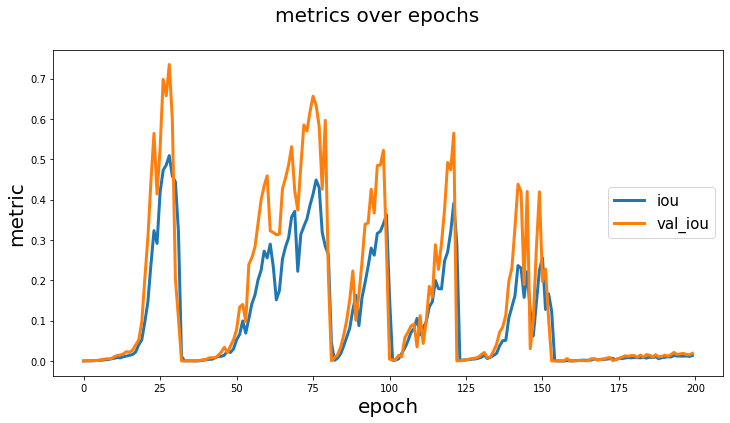

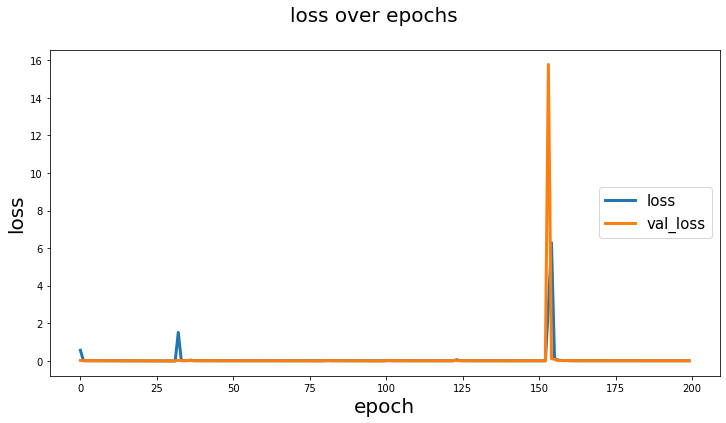

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

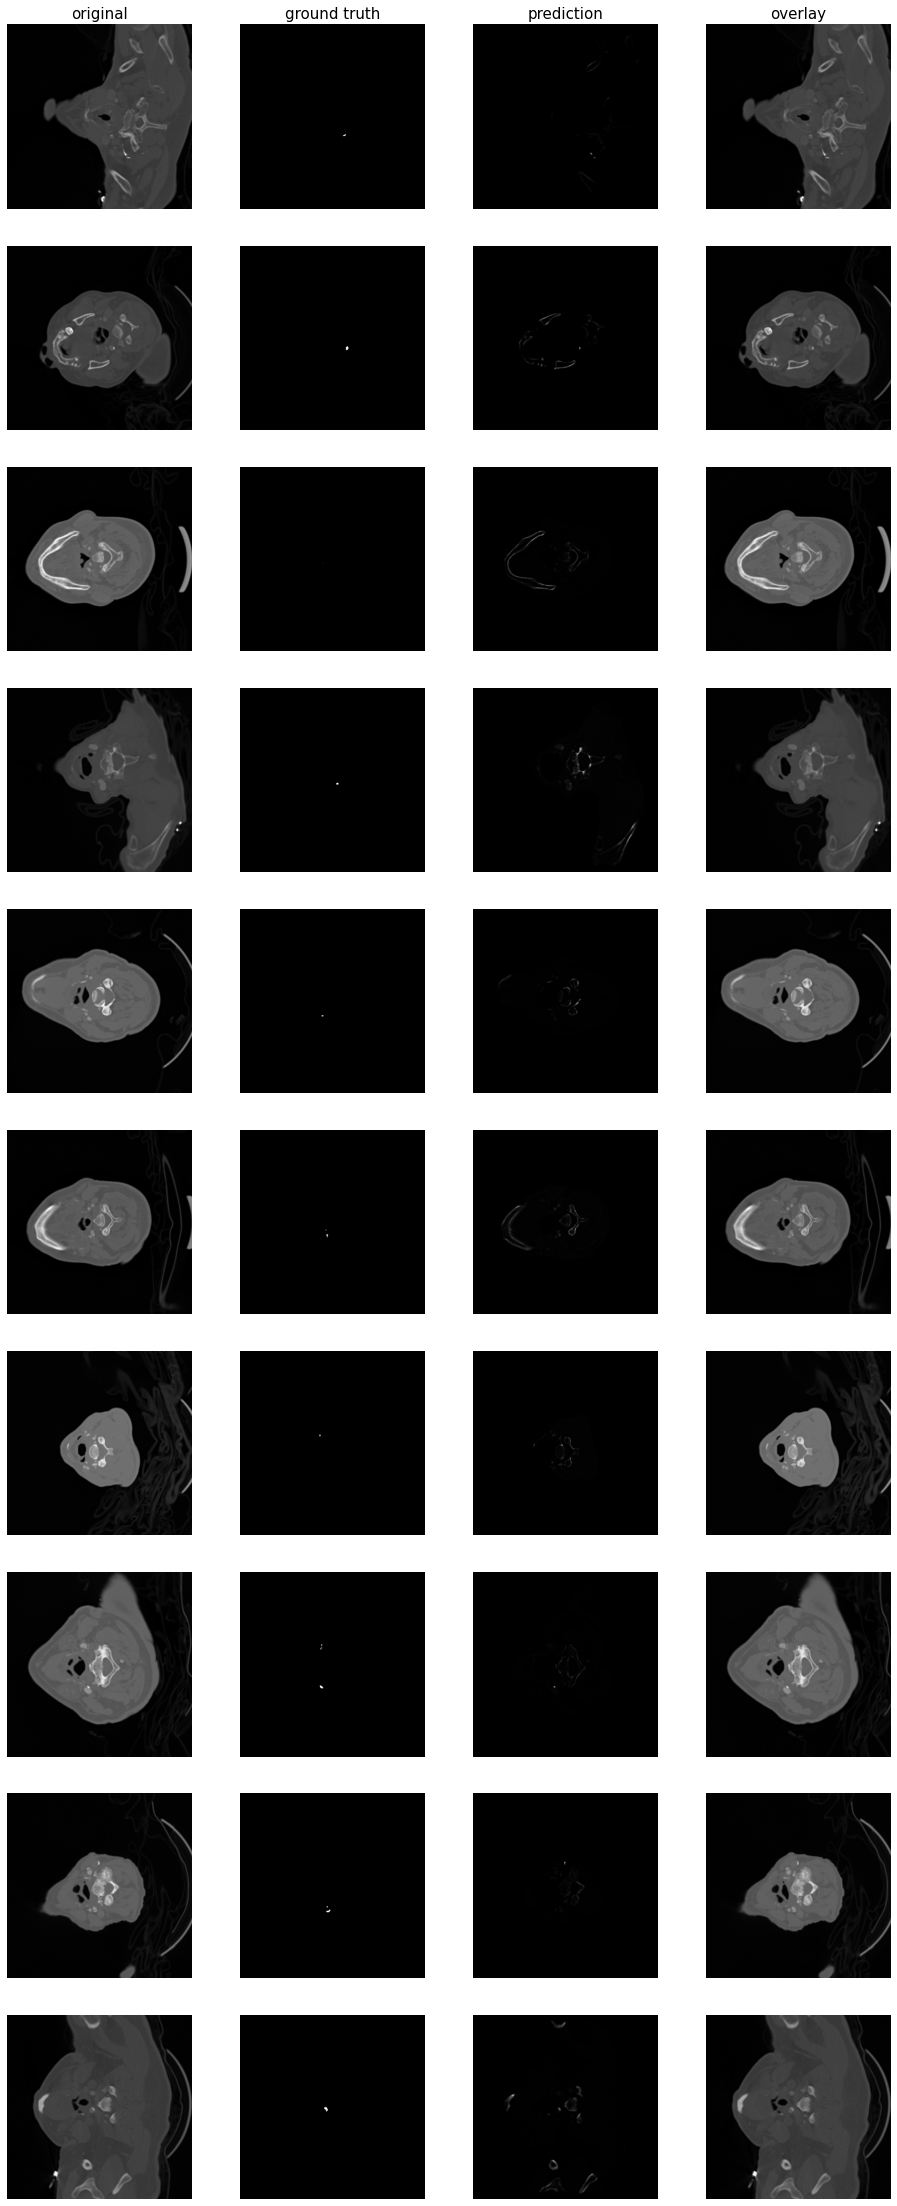

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 202ms/step - loss: 0.0031 - iou: 0.0191 - iou_thresholded: 0.0024
